In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import seaborn as sns
import pickle 

import torch
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from PIL import Image
from sklearn import model_selection
import json
import random

In [ ]:
real_vids = os.listdir('face_data\\Celeb-real')
fake_vids = os.listdir('face_data\\Celeb-synthesis')

In [ ]:
real_fake_pairs = []
for real in tqdm(real_vids):
    for fake in fake_vids:
        _ = fake.split('_')
        fake_id = _[0] + '_' + _[2]
        if(fake_id == real):
            real_fake_pairs.append([real,fake])

In [66]:
n_id = set()
for real in real_vids:
    n_id.add(real.split('_')[0])
for real in os.listdir('face_data\\YouTube-real'):
    n_id.add(real)
len(n_id)

359

In [68]:
df = pd.DataFrame(n_id, columns=['orig']).sample(frac=1).reset_index(drop=True)
df['fold'] = -1
kf = model_selection.KFold(n_splits=10)
for f, (t_, v_) in enumerate(kf.split(X=df)):
    df.loc[v_, 'fold'] = f

In [69]:
meta_df = pd.DataFrame(real_fake_pairs, columns=['original','fake'])
meta_df['original_id'] = [x.split('_')[0] for x in meta_df['original']]
meta_df['fold'] = -1

In [72]:
meta_df.head()

,original,fake,original_id,fold
0,id0_0000.mp4,id0_id16_0000.mp4,id0,8
1,id0_0000.mp4,id0_id17_0000.mp4,id0,8
2,id0_0000.mp4,id0_id1_0000.mp4,id0,8
3,id0_0000.mp4,id0_id20_0000.mp4,id0,8
4,id0_0000.mp4,id0_id21_0000.mp4,id0,8


In [71]:
for i, row in meta_df.iterrows():
    id = row['original_id']
    val = df[df['orig'] == id]['fold'].values[0]
    meta_df.set_value(i, 'fold', val)

In [75]:
df.to_json('original_folds.json', orient='records')

In [81]:
original_folds = []
for real in real_vids:
    id = real.split('_')[0]
    val = int(df[df['orig'] == id]['fold'].values[0])
    original_folds.append({
        'video' : os.path.join('face_data\\Celeb-real', real),
        'fold' : val
    })
for real in os.listdir('face_data\\YouTube-real'):
    val = int(df[df['orig'] == real]['fold'].values[0])
    original_folds.append({
        'video' : os.path.join('face_data\\YouTube-real', real),
        'fold' : val
    })

In [3]:
with open("metadata.json", "r") as read_file:
        metadata = json.load(read_file)

In [12]:
meta = []

for item in metadata:
    meta.append({
        'name' : item['fake'],
        'label' : 1,
        'vid_path' : os.path.join('face_data\\Celeb-synthesis', item['fake']),
        'original_path' : os.path.join('face_data\\Celeb-real', item['original']),
        'original_id' : item['original_id'],
        'fold' : item['fold'],
        'bbox_path' : os.path.join('face_data\\boxes',item['original'].split('.')[0] + '.json')
    })
    
    

In [8]:
with open("original_folds.json", "r") as read_file:
        original_folds = json.load(read_file)

In [13]:
for item in original_folds:
    _ = item['video'].split('\\')
    if(_[1] == 'Celeb-real'):
        original_id = _[2].split('_')[0]
    else:
        original_id = _[2].split('.')[0]
    
    meta.append({
        'name' : item['video'].split('\\')[-1],
        'label' : 0,
        'vid_path' : item['video'],
        'original_path' : item['video'],
        'original_id' : original_id,
        'fold' : item['fold'],
        'bbox_path' : os.path.join('face_data\\boxes', item['video'].split('\\')[-1].split('.')[0] + '.json')
    })

In [16]:
with open('meta.json', 'w') as fout:
    json.dump(meta , fout)

In [19]:
paths = []

for item in meta:
    name = item['name'][:-4]
    imgs = os.listdir(os.path.join('face_data','face_crops',name))

    for f in imgs:
        if f.endswith('txt'):
            continue
        label = item['label']
        fold = item['fold']
        video = name
        ori_vid = item['original_path']
        paths.append([video, f, label, ori_vid, int(f.split("_")[0]), fold])

In [24]:
random.shuffle(paths)
pd.DataFrame(paths, columns=["video", "file", "label", "original_path", "frame", "fold"]).to_csv('folds.csv', index=False)

In [2]:
from dataset import CelebDF_Dataset

train_data = CelebDF_Dataset(data_root='face_data',folds_csv='folds.csv', hardcore=True)
train_data.reset(777)

real 31972 fakes 31972 mode train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


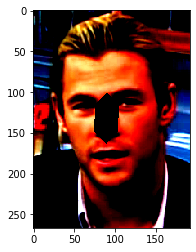

In [3]:
item = train_data[1]
plt.imshow(item['image'].permute(1, 2, 0))
plt.show()